# **Movie Recommendation System**

by Azhar Rizki Zulma

Dataset: https://www.kaggle.com/sunilgautam/movielens

# Pendahuluan

Tema dari analisis ini adalah hiburan dimana hasilnya akan berupa model machine learning yang nanti dapat digunakan untuk dijadikan sebuah sistem rekomendasi film

# Data Loading
## Import Library

In [1]:
import zipfile
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
%matplotlib inline

from google.colab import files
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

## Install Kaggle Library

In [2]:
!pip install -q kaggle

## Upload Kaggle Credential API Token

In [3]:
uploaded = files.upload()

Saving kaggle.json to kaggle.json


## Credential API Verification

In [4]:
!chmod 600 /content/kaggle.json

## Download Data

In [5]:
! KAGGLE_CONFIG_DIR=/content/ kaggle datasets download -d sunilgautam/movielens

  0% 0.00/971k [00:00<?, ?B/s]
100% 971k/971k [00:00<00:00, 42.6MB/s]


## Extract Data

In [6]:
local_zip = '/content/movielens.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

## Data Understanding

Dataset ini bersumber dari kaggle dimana memiliki 4 file data yaitu:

- links.csv
- ratings.csv
- movies.csv
- tags.csv

Dari keempat file diatas data yang akan kita gunakan hanya dua yaitu data pada file ratings.csv dan juga movies.csv

## Read Dataset

In [7]:
ratings = pd.read_csv('/content/ml-latest-small/ratings.csv')
movies = pd.read_csv('/content/ml-latest-small/movies.csv')

movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [8]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


# Exploratory Data Analysis
## Univariate Analysis
### Deskripsi Variabel
- Variabel file movies.csv:
  - movieId = ID dari film
  - title = Judul dari film
  - genres = Genre dari film

- Variabel file ratings.csv:
  - userId = ID pengguna
  - movieId = ID film yang diberi rating
  - rating = Skor dari rating yang diberikan
  - timestamp = Waktu rating terekam
  
### Melihat Infromasi Data

In [9]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


In [10]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [11]:
ratings.rating.value_counts()

4.0    26818
3.0    20047
5.0    13211
3.5    13136
4.5     8551
2.0     7551
2.5     5550
1.0     2811
1.5     1791
0.5     1370
Name: rating, dtype: int64

Terlihat dari informasi data rating diatas bahwa rating memiliki maksimal 5 bintang dengan skala 0.5

### Menghitung Total Data

In [12]:
print(f'Jumlah data Movie sebanyak {movies.shape[0]}, dan memiliki {movies.shape[1]} kolom')
print(f'Jumlah data Rating sebanyak {ratings.shape[0]}, dan memiliki {ratings.shape[1]} kolom')

Jumlah data Movie sebanyak 9742, dan memiliki 3 kolom
Jumlah data Rating sebanyak 100836, dan memiliki 4 kolom


### Mengecek Missing Value

In [13]:
movies.isnull().sum()
#movies.isna().sum()

movieId    0
title      0
genres     0
dtype: int64

In [14]:
ratings.isnull().sum()
#ratings.isna().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

Terlihat diatas bahwasannya tidak terdapat missing value pada kedua dataframe diatas, baik data film maupun data rating.

### Mengecek Data Duplikat

In [15]:
movies.duplicated().sum()

0

In [16]:
ratings.duplicated().sum()

0

Terlihat dari hasil diatas tidak terdapat data duplikat pada kedua dataframe diatas, baik data film maupun data rating.

### Menghitung Total Data Unik

In [17]:
movies.nunique()

movieId    9742
title      9737
genres      951
dtype: int64

Terlihat dari hasil diatas, terdapat 9742 data unik pada variabel movieId, 9737 data unik pada variabel title dan 951 data unik pada variabel genres

In [18]:
ratings.nunique()

userId         610
movieId       9724
rating          10
timestamp    85043
dtype: int64

Terlihat dari hasil diatas, terdapat 610 data unik pada variabel userId, 9724 data unik pada variabel movieId, 10 data unik pada variabel rating dan 85043 data unik pada variabel timestamp

### Menganalisa Distribusi Sebaran Tahun Rilis Film

In [19]:
movies_year = movies.copy()
movies_year['year'] = movies['title'].str.extract('(\d+)').astype(float)
movies_year.year.dropna(inplace=True)

Melakukan deklarasi variabel baru bernama movies_year, lalu melakukan konversi pada variabel title dari bertipe data object menjadi tipe data string dan mengektrak tahun yang terdapat kurung didalamnya dan merubah tahun tersebut menjadi bentuk float, setelah itu melakukan drop missing value pada film yang tidak memiliki tahun

In [20]:
new_movies_year = movies_year[movies_year['year'] > 1000.0]
new_movies_year.year.astype(int)
data = new_movies_year

Membuat variabel baru lalu menyaring variabel year (diatas 1000) yang diekstrak menggunakan kurung tadi untuk mengantisipasi lolosnya variabel lain selain variabel tahun. lalu merubah tipe datanya menjadi integer.

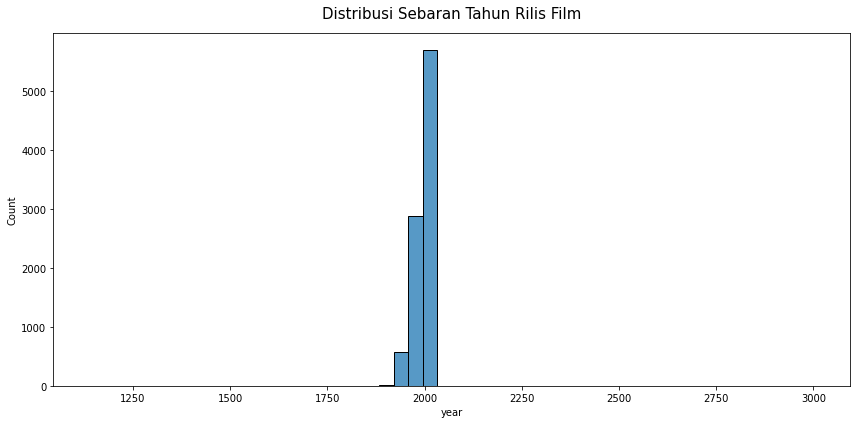

In [21]:
plt.figure(figsize=(12,6))
sns.histplot(data=data, x='year',bins=50)
plt.title('Distribusi Sebaran Tahun Rilis Film', fontsize=15, pad=15)
plt.tight_layout()
plt.show()

Hasil analisis dari grafik diatas ialah distribusi terbanyak terjadi diatas tahun 2000, dimana distribusi film cenderung mengalami kenaikan secara signifkan setiap berjalannya waktu.

### Menganalisa Distribusi Sebaran Genre Film

In [22]:
movies_genres = movies.copy()
genres=[]
for i in range(len(movies.genres)):
    for x in movies.genres[i].split('|'):
        if x not in genres:
            genres.append(x)
genres

['Adventure',
 'Animation',
 'Children',
 'Comedy',
 'Fantasy',
 'Romance',
 'Drama',
 'Action',
 'Crime',
 'Thriller',
 'Horror',
 'Mystery',
 'Sci-Fi',
 'War',
 'Musical',
 'Documentary',
 'IMAX',
 'Western',
 'Film-Noir',
 '(no genres listed)']

Karena sebuah film memiliki banyak genre, maka untuk memisahkannya kita dapat menggunakan fungsi split yang tersedia pada python, dimana jika kita lihat preview data diatas bahwasannya variabel genres film yang memiliki lebih dari satu dipisahkan dengan "|", lalu kita masukkan dalam sebuah list.


In [23]:
for x in genres:
    movies_genres[x] = 0

for i in range(len(movies.genres)):
    for x in movies.genres[i].split('|'):
        movies_genres[x][i]=1

movies_genres.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,movieId,title,genres,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,Action,Crime,Thriller,Horror,Mystery,Sci-Fi,War,Musical,Documentary,IMAX,Western,Film-Noir,(no genres listed)
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),Adventure|Children|Fantasy,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),Comedy|Romance,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5,Father of the Bride Part II (1995),Comedy,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Menambahkan setiap genres untuk menjadi variabel/kolom pada dataframe agar mempermudah proses selanjutnya nantinya.

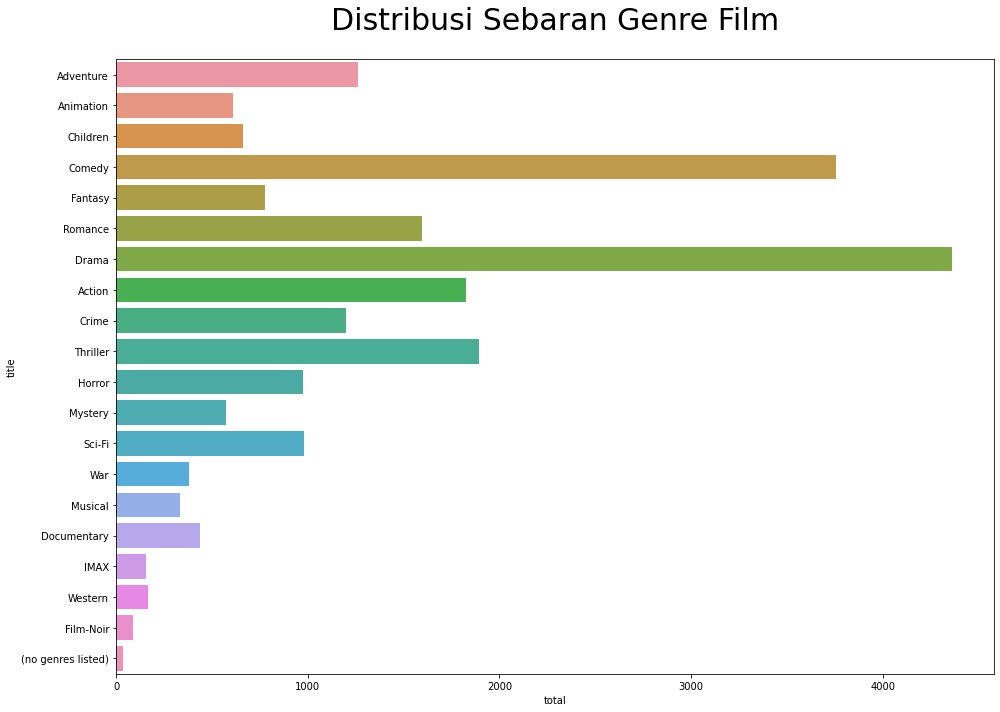

In [24]:
data = movies_genres.iloc[:,3:].sum().reset_index()
data.columns = ['title','total']

plt.figure(figsize=(14,10))
sns.barplot(y='title', x='total', data=data)
plt.title('Distribusi Sebaran Genre Film', fontsize=30, pad=30)
plt.tight_layout()
plt.show()

Dari hasil analisa pada grafik diatas didapat bahwasannya genre paling diminati dalam film ialah drama diikuti dengan genre komedi setelahnya dimana kedua genre tersebut hampir menguasai setengah data yang kita miliki

### Menganalisa Distribusi Sebaran Rating Film Tertinggi

In [25]:
print(f'Jumlah pengguna yang memberikan rating: {ratings.userId.nunique()}')
print(f'Jumlah film yang diberi rating oleh pengguna: {ratings.movieId.nunique()}')

Jumlah pengguna yang memberikan rating: 610
Jumlah film yang diberi rating oleh pengguna: 9724


In [26]:
rating_movies = pd.merge(ratings, movies, on='movieId', how='inner')
rating_movies.drop(['timestamp','genres'],axis=1, inplace=True)
rating_movies.head()

,userId,movieId,rating,title
0,1,1,4.0,Toy Story (1995)
1,5,1,4.0,Toy Story (1995)
2,7,1,4.5,Toy Story (1995)
3,15,1,2.5,Toy Story (1995)
4,17,1,4.5,Toy Story (1995)


Melakukan pendeklarasian variabel baru, lalu melakukan merge dataframe movies dan ratings berdasarkan relasi variabel movieId yang dimiliki kedua dataframe. Setelah itu melakukan drop untuk kolom/variabel genres dan timestamp yang tidak diperlukan pada analisa distribusi ini

In [27]:
rating_movies_count = rating_movies.groupby('title')['rating'].count()
rating_movies_count = pd.DataFrame(rating_movies_count).reset_index().rename(columns={'rating':'total_rating'})
rating_movies_count.head()

,title,total_rating
0,'71 (2014),1
1,'Hellboy': The Seeds of Creation (2004),1
2,'Round Midnight (1986),2
3,'Salem's Lot (2004),1
4,'Til There Was You (1997),2


Melakukan perhitungan total rating berdasarkan title film agar tidak terjadi duplikasi data

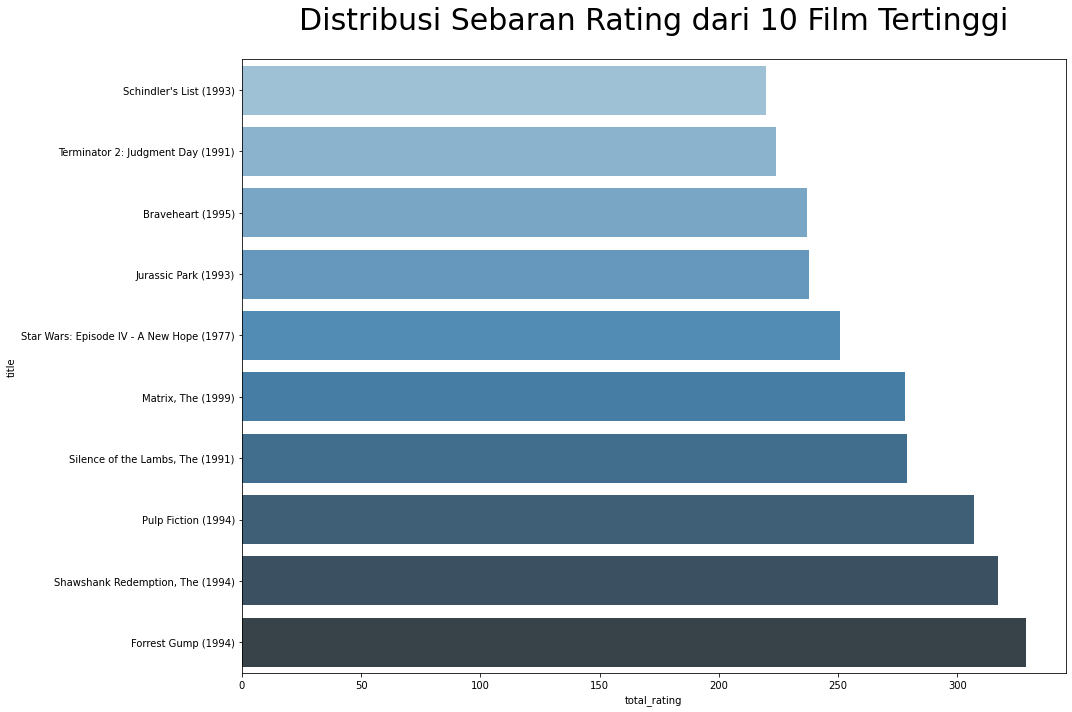

In [28]:
data = rating_movies_count.sort_values(by ='total_rating')

plt.figure(figsize=(15,10))
sns.barplot(data=data.iloc[-10:,:], 
            y='title', x='total_rating',
            palette="Blues_d")
plt.title('Distribusi Sebaran Rating dari 10 Film Tertinggi', pad=30, fontsize=30)
plt.tight_layout()
plt.show()

Terlihat pada grafik bahwasannya film yang memiliki rating tertinggi adalah Forrest Gump yang rilis pada tahun 1994


# Data Preparation
## Melakukan Pembersihan Data Missing Value

In [29]:
movies.dropna(axis=0, inplace=True)
ratings.dropna(axis=0, inplace=True)

## Melakukan Sorting Data Rating berdasarkan ID Pengguna

In [30]:
ratings = ratings.sort_values('userId').astype('int')

Merubah data rating menjadi integer

## Menghapus Data Duplikat

In [31]:
movies.drop_duplicates(subset=['title'], keep='first', inplace=True)
ratings.drop_duplicates(subset=['userId','movieId'], keep='first', inplace=True)

Menghapus data duplikat berdasarkan title pada dataframe movies dan juga userId dan movieId pada dataframe ratings dan membiarkan satu data tersisa

## Melakukan penggabungan Data

In [32]:
merge_df = pd.merge(ratings, movies, how='left', on='movieId')
df = merge_df.copy().drop('timestamp', axis=1)
df.head()

,userId,movieId,rating,title,genres
0,1,1,4,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,2329,5,American History X (1998),Crime|Drama
2,1,2338,2,I Still Know What You Did Last Summer (1998),Horror|Mystery|Thriller
3,1,2353,5,Enemy of the State (1998),Action|Thriller
4,1,2366,4,King Kong (1933),Action|Adventure|Fantasy|Horror


In [33]:
df = df[~pd.isnull(df['genres'])]
df.shape

(100830, 5)

Menghapus data yang memiliki missing value pada variabel genres dan melihat jumlah data setelah digabungkan, terlihat data memiliki 100830 baris dengan 5 kolom

# Model Development
## Content Based Filtering
### TF-IDF Vectorizer

In [34]:
tfid = TfidfVectorizer(stop_words='english')
tfid.fit(movies['genres'])
tfid.get_feature_names()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['action',
 'adventure',
 'animation',
 'children',
 'comedy',
 'crime',
 'documentary',
 'drama',
 'fantasy',
 'fi',
 'film',
 'genres',
 'horror',
 'imax',
 'listed',
 'musical',
 'mystery',
 'noir',
 'romance',
 'sci',
 'thriller',
 'war',
 'western']

Melakukan inisialisasi TfidfVectorizer, lalu melakukan perhitungan idf pada data film dan melakukan mapping array dari fitur index integer ke fitur nama

### Transform Data ke Matriks

In [35]:
tfidf_matrix = tfid.fit_transform(movies['genres']) 
tfidf_matrix.shape

(9737, 23)

Melakukan transform data ke matriks berdasarkan genre

### Menghitung Cosine Similarity

In [36]:
cosine_sim = cosine_similarity(tfidf_matrix)
cosine_sim

array([[1.        , 0.81357359, 0.15270879, ..., 0.        , 0.42101966,
        0.2675912 ],
       [0.81357359, 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.15270879, 0.        , 1.        , ..., 0.        , 0.        ,
        0.57067944],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.42101966, 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.2675912 , 0.        , 0.57067944, ..., 0.        , 0.        ,
        1.        ]])

### Membuat dataframe baru berdasarkan Cosine Similarity

In [37]:
cosine_sim_df = pd.DataFrame(cosine_sim, index=movies['title'],
                             columns=movies['title'])
print('Shape:', cosine_sim_df.shape)

cosine_sim_df.sample(10, axis=1).sample(10, axis=0)

Shape: (9737, 9737)


title,Fuzz (1972),Pokémon Heroes (2003),Black Sheep (1996),Crazy Heart (2009),From Up on Poppy Hill (Kokuriko-zaka kara) (2011),Rent-a-Kid (1995),Murder at 1600 (1997),"Last Metro, The (Dernier métro, Le) (1980)",Final Flight of the Osiris (2003),Temple Grandin (2010)
title,,,,,,,,,,
Village of the Damned (1995),0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.580086,0.000000
Wild Hogs (2007),0.000000,0.000000,0.540223,0.000000,0.000000,0.540223,0.000000,0.000000,0.000000,0.000000
Intouchables (2011),0.678501,0.000000,0.734599,0.366512,0.243104,0.734599,0.208445,0.366512,0.000000,0.678501
Adventures Of Sherlock Holmes And Dr. Watson: The Twentieth Century Approaches (1986),0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.838883,0.000000,0.000000,0.000000
Desperately Seeking Susan (1985),0.466289,0.000000,0.504842,0.863212,0.572560,0.504842,0.143250,0.863212,0.000000,0.466289
"Watcher in the Woods, The (1980)",0.000000,0.379449,0.000000,0.000000,0.000000,0.000000,0.542917,0.000000,0.000000,0.000000
Brazil (1985),0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.566773,0.000000
"Adventures of Ichabod and Mr. Toad, The (1949)",0.000000,1.000000,0.000000,0.000000,0.535038,0.000000,0.000000,0.000000,0.410340,0.000000
Throw Momma from the Train (1987),0.000000,0.000000,0.533647,0.000000,0.000000,0.533647,0.445786,0.000000,0.000000,0.000000


Terlihat diatas hasil dari similarity matrix pada setiap film

### Uji Coba Model Content Based Filtering
#### Membuat Function untuk Merekomendasikan 10 Film yang Mirip

In [38]:
def MovieRecommendations(movies_title, similarity_data=cosine_sim_df, 
                         items=movies[['movieId','title','genres']], k=10):
  
    ''' Mengambil data menggunakan argpartition untuk partisi secara tidak langsung,
    sepanjang sumbu yang diberikan, kemudian dataframe diubah menjadi numpy Range 
    dengan parameter sebagai berikut (start, stop, step) '''
    index = similarity_data.loc[:, movies_title].to_numpy().argpartition(
        range(-1, -k, -1)
    )

    closest = similarity_data.columns[index[-1:-(k+2):-1]]

    closest = closest.drop(movies_title, errors='ignore')

    return pd.DataFrame(closest).merge(items).head(k)

Mengambil data dengan similarity terbesar dari index yang ada, lalu melakukan drop movie_title agar nama movie yang dicari tidak muncul dalam daftar rekomendasi

#### Melakukan Pengecekan Data Film

In [39]:
find_title = movies[movies['title'] == 'Daddy Day Care (2003)']
find_title

,movieId,title,genres
4339,6338,Daddy Day Care (2003),Children|Comedy


Melakukan pengecekan data film berdasarkan title. Dapat dilihat bahwa judul film Daddy Day Care (2003) memiliki genre Children dan Family

#### Mengujicoba Model Rekomendasi Content Based Filtering

In [40]:
movie_title = 'Daddy Day Care (2003)'
movie_recomend = MovieRecommendations(movie_title)
movie_recomend

,title,movieId,genres
0,"Cat in the Hat, The (2003)",6951,Children|Comedy
1,Blank Check (1994),2036,Children|Comedy
2,Home Alone 2: Lost in New York (1992),2953,Children|Comedy
3,Air Bud: Golden Receiver (1998),2152,Children|Comedy
4,Blackbeard's Ghost (1968),2035,Children|Comedy
5,Madeline (1998),1919,Children|Comedy
6,Paddington (2014),117887,Children|Comedy
7,"Love Bug, The (1969)",1010,Children|Comedy
8,Ernest Rides Again (1993),69227,Children|Comedy
9,Son of Flubber (1963),2098,Children|Comedy


Dari 10 rekomendasi yang sistem berikan, 10 judul film tersebut memiliki genre yang sama dengan yaitu Children dan Family

## Collaborative Filtering
### Melakukan Encoding pada ID Pengguna

In [41]:
user_id = df['userId'].unique().tolist()
print(f'list userId: {user_id}')
 
user_to_user_encoded = {x: i for i, x in enumerate(user_id)}
print(f'\nencoded userId: {user_to_user_encoded}')
 
user_encoded_to_user = {i: x for i, x in enumerate(user_id)}
print(f'\nencoded number to userId: {user_encoded_to_user}')

list userId: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219,

Mengubah unique userId menjadi list, lalu melakukan encoding userId, dan terakhir mengubah encoding angka ke userId

### Melakukan Encoding pada ID Film

In [42]:
movie_id = df['movieId'].unique().tolist()
print(f'list movieId: {movie_id}')
 
movie_to_movie_encoded = {x: i for i, x in enumerate(movie_id)}
print(f'\nencoded movieId: {movie_to_movie_encoded}')
 
movie_encoded_to_movie = {i: x for i, x in enumerate(movie_id)}
print(f'\nencoded number to movieId: {movie_encoded_to_movie}')

list movieId: [1, 2329, 2338, 2353, 2366, 2387, 2389, 2395, 2406, 2414, 2427, 2450, 2459, 2470, 2478, 2492, 2502, 2528, 2529, 2542, 2571, 2580, 2596, 2616, 2617, 2628, 2291, 2640, 2273, 2253, 2005, 2012, 2018, 2028, 2033, 2046, 2048, 2054, 2058, 2078, 2090, 2093, 2094, 2096, 2099, 2105, 2115, 2116, 2137, 2139, 2141, 2143, 2161, 2174, 2193, 2268, 2641, 2644, 2648, 3247, 3253, 3273, 3386, 3439, 3440, 3441, 3448, 3450, 3479, 3489, 3527, 3578, 3617, 3639, 3671, 3702, 3703, 3729, 3740, 3744, 3793, 3809, 4006, 5060, 3243, 3176, 3168, 3062, 2654, 2657, 2692, 2700, 2716, 2761, 2797, 2826, 2858, 2872, 2899, 2916, 2000, 2944, 2948, 2949, 2959, 2985, 2987, 2991, 2993, 2997, 3033, 3034, 3052, 3053, 2947, 1967, 3147, 1927, 543, 552, 553, 590, 593, 596, 608, 648, 661, 673, 733, 736, 780, 804, 919, 923, 940, 943, 954, 1009, 1023, 1024, 1025, 1029, 1030, 527, 1031, 500, 457, 1954, 3, 6, 47, 50, 70, 101, 110, 151, 157, 163, 216, 223, 231, 235, 260, 296, 316, 333, 349, 356, 362, 367, 423, 441, 480, 1032

Mengubah unique movieId menjadi list, lalu melakukan encoding movieId, dan terakhir mengubah encoding angka ke movieId

### Melakukan Mapping pada ID Pengguna dan ID Film

In [43]:
df['user'] = df['userId'].map(user_to_user_encoded)
df['movie'] = df['movieId'].map(movie_to_movie_encoded)
df.head()

,userId,movieId,rating,title,genres,user,movie
0,1,1,4,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,0
1,1,2329,5,American History X (1998),Crime|Drama,0,1
2,1,2338,2,I Still Know What You Did Last Summer (1998),Horror|Mystery|Thriller,0,2
3,1,2353,5,Enemy of the State (1998),Action|Thriller,0,3
4,1,2366,4,King Kong (1933),Action|Adventure|Fantasy|Horror,0,4


Melakukan mapping userId ke dataframe user dan melakukan mapping movie_id ke dataframe movie


In [44]:
num_users = len(user_to_user_encoded)
num_movie = len(movie_encoded_to_movie)
df['rating'] = df['rating'].values.astype(np.float32)
min_rating = min(df['rating'])
max_rating = max(df['rating'])

print(f'Number of User: {num_users}')
print(f'Number of Movie: {num_movie}')
print(f'Min rating: {min_rating}')
print(f'Max rating: {max_rating}')

Number of User: 610
Number of Movie: 9719
Min rating: 0.0
Max rating: 5.0


Mendapatkan jumlah pengguna dan film, lalu merubah tipe data variabel rating menjadi float, lalu melihat nilai maksimum dan nilai minimum pada rating

### Melakukan Pembagian Data untuk Training dan Validasi
#### Mengacak Dataset

In [45]:
df = df.sample(frac=1, random_state=42)
df.head()

,userId,movieId,rating,title,genres,user,movie
27969,191,99,5.0,Heidi Fleiss: Hollywood Madam (1995),Documentary,190,5551
44012,294,2060,2.0,BASEketball (1998),Comedy,293,1463
70876,453,3536,4.0,Keeping the Faith (2000),Comedy|Drama|Romance,452,1520
6188,42,292,3.0,Outbreak (1995),Action|Drama|Sci-Fi|Thriller,41,660
34902,233,2858,3.0,American Beauty (1999),Drama|Romance,232,96


#### Membuat Variabel Training dan Validasi

In [46]:
x = df[['user', 'movie']].values
y = df['rating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
train_indices = int(0.8 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)

Mendeklarasikan variabel x untuk mencocokkan data pengguna dan film menjadi satu value, lalu membuat variabel y untuk rating dari hasil, dan selanjutnya ialah membagi data train sebesar 80% dan data validasi sebesar 20%

### Pelatihan Model
#### Pembuatan kelas dan Inisialisasi Fungsi

In [47]:
class RecommenderNet(tf.keras.Model):
  def __init__(self, num_users, num_movie, embedding_size, **kwargs):
    super(RecommenderNet, self).__init__(**kwargs)
    self.num_users = num_users
    self.num_movie = num_movie
    self.embedding_size = embedding_size
    self.user_embedding = layers.Embedding(
        num_users,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(5e-7)
    )
    self.user_bias = layers.Embedding(num_users, 1)
    self.movie_embedding = layers.Embedding(
        num_movie,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(5e-7)
    )
    self.movie_bias = layers.Embedding(num_movie, 1)
 
  def call(self, inputs):
    user_vector = self.user_embedding(inputs[:,0])
    user_bias = self.user_bias(inputs[:, 0])
    movie_vector = self.movie_embedding(inputs[:, 1])
    movie_bias = self.movie_bias(inputs[:, 1])
 
    dot_user_movie = tf.tensordot(user_vector, movie_vector, 2) 
 
    x = dot_user_movie + user_bias + movie_bias
    
    return tf.nn.sigmoid(x)

#### Memanggil Kelas, Mengcompile Model dan Membuat Callback

In [48]:
model = RecommenderNet(num_users, num_movie, 50) # inisialisasi model

model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate=0.001),
    metrics=[[tf.keras.metrics.MeanAbsoluteError(),tf.keras.metrics.RootMeanSquaredError()]]
)
callbacks = EarlyStopping(
    min_delta=0.0001,
    patience=7,
    restore_best_weights=True,
)

#### Melakukan Pelatihan Model

In [49]:
history = model.fit(
    x = x_train,
    y = y_train,
    batch_size = 8,
    epochs = 100,
    validation_data = (x_val, y_val),
    callbacks=[callbacks]
)

Epoch 1/100
10083/10083 [==============================] - 61s 6ms/step - loss: 0.6271 - mean_absolute_error: 0.1676 - root_mean_squared_error: 0.2109 - val_loss: 0.6126 - val_mean_absolute_error: 0.1518 - val_root_mean_squared_error: 0.1944
Epoch 2/100
10083/10083 [==============================] - 55s 5ms/step - loss: 0.6065 - mean_absolute_error: 0.1456 - root_mean_squared_error: 0.1874 - val_loss: 0.6096 - val_mean_absolute_error: 0.1490 - val_root_mean_squared_error: 0.1910
Epoch 3/100
10083/10083 [==============================] - 55s 5ms/step - loss: 0.6026 - mean_absolute_error: 0.1416 - root_mean_squared_error: 0.1827 - val_loss: 0.6079 - val_mean_absolute_error: 0.1469 - val_root_mean_squared_error: 0.1890
Epoch 4/100
10083/10083 [==============================] - 55s 5ms/step - loss: 0.6007 - mean_absolute_error: 0.1395 - root_mean_squared_error: 0.1802 - val_loss: 0.6075 - val_mean_absolute_error: 0.1463 - val_root_mean_squared_error: 0.1884
Epoch 5/100
10083/10083 [=======

### Uji Coba Model Collaborative Filtering
#### Mengambil Data Sample Pengguna

In [50]:
user_ID = df.userId.sample(1).iloc[0]
movie_watched_by_user = df[df.userId == user_ID]
 
movie_not_watched = movies[~movies['movieId'].isin(movie_watched_by_user.movieId.values)]['movieId'] 
movie_not_watched = list(
    set(movie_not_watched)
    .intersection(set(movie_to_movie_encoded.keys()))
)

 
movie_not_watched = [[movie_to_movie_encoded.get(x)] for x in movie_not_watched]
user_encoder = user_to_user_encoded.get(user_ID)
user_movie_array = np.hstack(
    ([[user_encoder]] * len(movie_not_watched), movie_not_watched)
)

#### Mengujicoba Model Rekomendasi Collaborative Filtering

In [51]:
ratings = model.predict(user_movie_array).flatten()
 
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_movie_ids = [
    movie_encoded_to_movie.get(movie_not_watched[x][0]) for x in top_ratings_indices
]
 
print('Showing recommendations for users: {}'.format(user_ID))
print('====' * 10)
print('movie with high ratings from user')
print('----' * 8)
 
top_movie_user = (
    movie_watched_by_user.sort_values(
        by = 'rating',
        ascending=False
    )
    .head(5)
    .movieId.values
)
 
movie_df_rows = movies[movies['movieId'].isin(top_movie_user)]
for row in movie_df_rows.itertuples():
    print(row.title)
 
print('----' * 8)
print('Top 10 movie recommendation')
print('----' * 8)
 
recommended_movie = movies[movies['movieId'].isin(recommended_movie_ids)]
for row in recommended_movie.itertuples():
    print(row.title)

Showing recommendations for users: 606
movie with high ratings from user
--------------------------------
Pulp Fiction (1994)
Manhattan (1979)
Metropolis (1927)
All About My Mother (Todo sobre mi madre) (1999)
Guess Who's Coming to Dinner (1967)
--------------------------------
Top 10 movie recommendation
--------------------------------
Raging Bull (1980)
Boot, Das (Boat, The) (1981)
Seventh Seal, The (Sjunde inseglet, Det) (1957)
Glory (1989)
Touch of Evil (1958)
Chinatown (1974)
Evil Dead II (Dead by Dawn) (1987)
Great Escape, The (1963)
Unforgiven (1992)
Manchurian Candidate, The (1962)


# Evaluation
Evaluasi yang akan saya lakukan disini yaitu evaluasi dengan Mean Absolute Error (MAE) dan Root Mean Squared Error (RMSE)
## Mean Absolute Error Plot

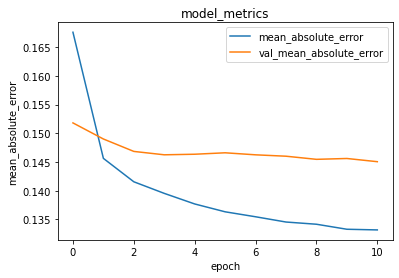

In [52]:
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model_metrics')
plt.ylabel('mean_absolute_error')
plt.xlabel('epoch')
plt.legend(['mean_absolute_error', 'val_mean_absolute_error'])
plt.show()

## Root Mean Squared Error Plot

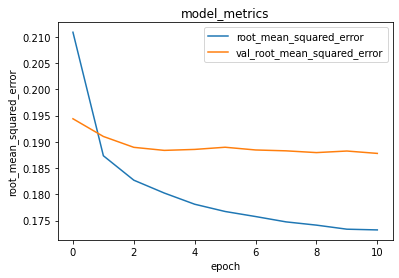

In [53]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model_metrics')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['root_mean_squared_error', 'val_root_mean_squared_error'])
plt.show()